In [1]:
import pandas as pd
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import random
import tensorflow as tf

from numpy import array
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [112]:
#memanggil dataset. Kolom yang dibutuhkan untuk analisis hanya kolom content
df = pd.read_csv('/content/tbl_cnn.csv') #dipilih hanya kolom content
data = df[['content']]
data

,content
0,Menteri Ketenagakerjaan (Menaker) Ida Fauziyah...
1,Anggota Komisi II DPR Fraksi Golkar Zulfikar A...
2,"Harga Batu bara Acuan (HBA) menguat 13,55 pers..."
3,Capaian jumlah vaksinasi Covid-19 di Indonesia...
4,Badan Nasional Penanggulangan Bencana (BNPB) m...
...,...
16787,"Gubernur Kalimantan Timur (Kaltim), Isran Noor..."
16788,NaN
16789,Langkah investasi PT Telkom Indonesia (Persero...
16790,Pembalap Maverick Vinales menyalahkan mekanik ...


In [113]:
#check NaN
data.isna().sum()

content    2773
dtype: int64

In [114]:
#remove NaN
df=data.dropna()
df

,content
0,Menteri Ketenagakerjaan (Menaker) Ida Fauziyah...
1,Anggota Komisi II DPR Fraksi Golkar Zulfikar A...
2,"Harga Batu bara Acuan (HBA) menguat 13,55 pers..."
3,Capaian jumlah vaksinasi Covid-19 di Indonesia...
4,Badan Nasional Penanggulangan Bencana (BNPB) m...
...,...
16785,Ketua Fraksi Demokrat DPRD Jawa Timur Sri Subi...
16786,Pengusaha mal yang tergabung dalam Asosiasi Pe...
16787,"Gubernur Kalimantan Timur (Kaltim), Isran Noor..."
16789,Langkah investasi PT Telkom Indonesia (Persero...


In [115]:
#labelling the dataset dengan polarity
df['label'] = ''
for i,x in df.content.iteritems():
    label = TextBlob(x)
    df['label'][i] = label.sentiment.polarity
    print("Index: ", i ,  "label" , label.sentiment.polarity)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


Streaming output truncated to the last 5000 lines.
Index:  10824 label 0.0
Index:  10825 label 0.0
Index:  10826 label -0.2
Index:  10827 label 0.2
Index:  10828 label 0.23809523809523808
Index:  10829 label 0.0
Index:  10830 label 0.06212121212121211
Index:  10831 label -0.03333333333333333
Index:  10832 label 0.0
Index:  10833 label 0.5
Index:  10834 label 0.075
Index:  10835 label 0.0
Index:  10837 label -0.2
Index:  10838 label 0.0
Index:  10839 label 0.0
Index:  10841 label -0.05
Index:  10842 label 0.0
Index:  10843 label 0.06818181818181818
Index:  10845 label 0.25
Index:  10847 label 0.0
Index:  10848 label 0.0
Index:  10850 label 0.10000000000000002
Index:  10852 label 0.0
Index:  10854 label 0.0
Index:  10855 label 0.0
Index:  10856 label -0.02
Index:  10857 label 0.0
Index:  10859 label 0.0
Index:  10860 label 0.0
Index:  10861 label 0.4
Index:  10862 label 0.0
Index:  10863 label 0.4
Index:  10864 label 0.24545454545454545
Index:  10865 label 0.2
Index:  10866 label 0.0
Ind

In [116]:
#mendefinisikan hasil polarity tiap-tiap baris apakah berlabel positif negatif maupun netral
def polarity_to_label(x):
    if(x >= -1 and x < 0):
        return 'neg'
    if(x == 0):
        return 'neutral'
    if(x > 0 and x <= 1):
        return 'pos'
df.label = df.label.apply(polarity_to_label)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [117]:
df.head()

,content,label
0,Menteri Ketenagakerjaan (Menaker) Ida Fauziyah...,pos
1,Anggota Komisi II DPR Fraksi Golkar Zulfikar A...,pos
2,"Harga Batu bara Acuan (HBA) menguat 13,55 pers...",pos
3,Capaian jumlah vaksinasi Covid-19 di Indonesia...,neutral
4,Badan Nasional Penanggulangan Bencana (BNPB) m...,neutral


In [118]:
#jumlah value masing-masing kelas label
df.label.value_counts()

neutral    9558
pos        2949
neg        1512
Name: label, dtype: int64

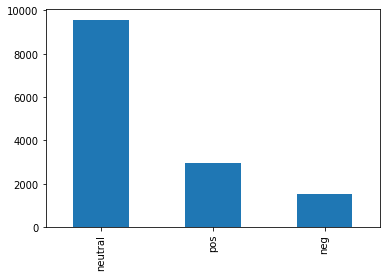

In [134]:
df['label'].value_counts().plot(kind='bar');

In [119]:
#cleansing data
import string, re

def cleansing(data) :
  #lower text
  data=data.lower()

  #hapus punctuation
  remove = string.punctuation
  translator = str.maketrans(remove, ' '*len(remove))
  data = data.translate(translator)

  #remove new line
  data = data.replace('\n', ' ')

  return data

In [120]:
#terapkan ke dalam dataset
review = []
for index, row in df.iterrows():
  review.append(cleansing(row["content"]))

df["content"] = review
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,content,label
0,menteri ketenagakerjaan menaker ida fauziyah...,pos
1,anggota komisi ii dpr fraksi golkar zulfikar a...,pos
2,harga batu bara acuan hba menguat 13 55 pers...,pos
3,capaian jumlah vaksinasi covid 19 di indonesia...,neutral
4,badan nasional penanggulangan bencana bnpb m...,neutral


In [63]:
!pip install Sastrawi

In [121]:
#stopword
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

factory = StopWordRemoverFactory()
stopword = factory.create_stop_word_remover()

review = []
for index, row in df.iterrows():
  review.append(stopword.remove(row["content"]))


df["content"] = review
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,content,label
0,menteri ketenagakerjaan menaker ida fauziyah...,pos
1,anggota komisi ii dpr fraksi golkar zulfikar a...,pos
2,harga batu bara acuan hba menguat 13 55 pers...,pos
3,capaian jumlah vaksinasi covid 19 di indonesia...,neutral
4,badan nasional penanggulangan bencana bnpb m...,neutral


In [65]:
!pip install wordcloud

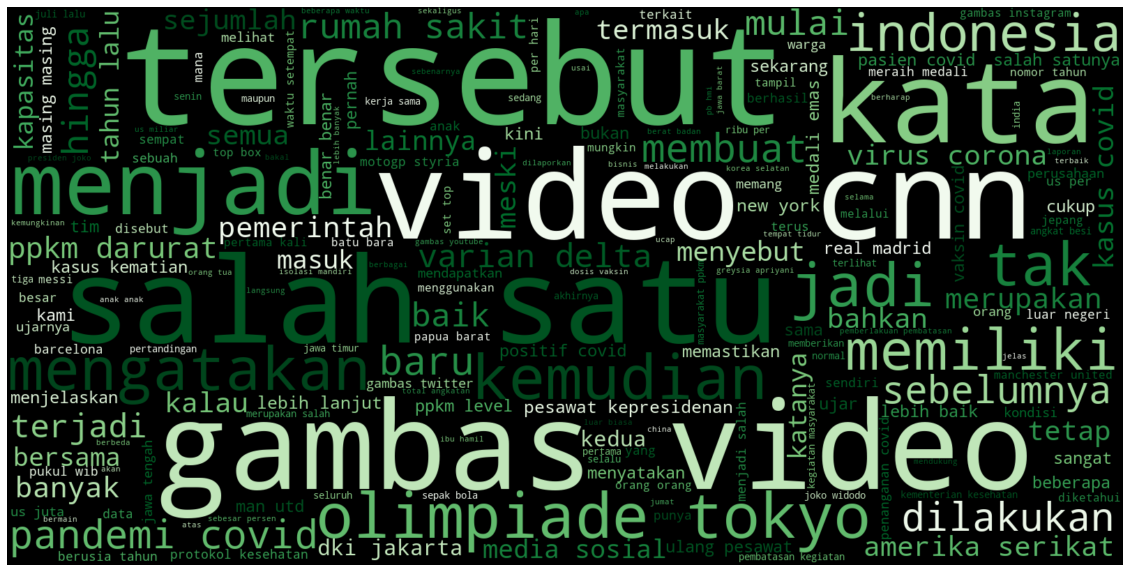

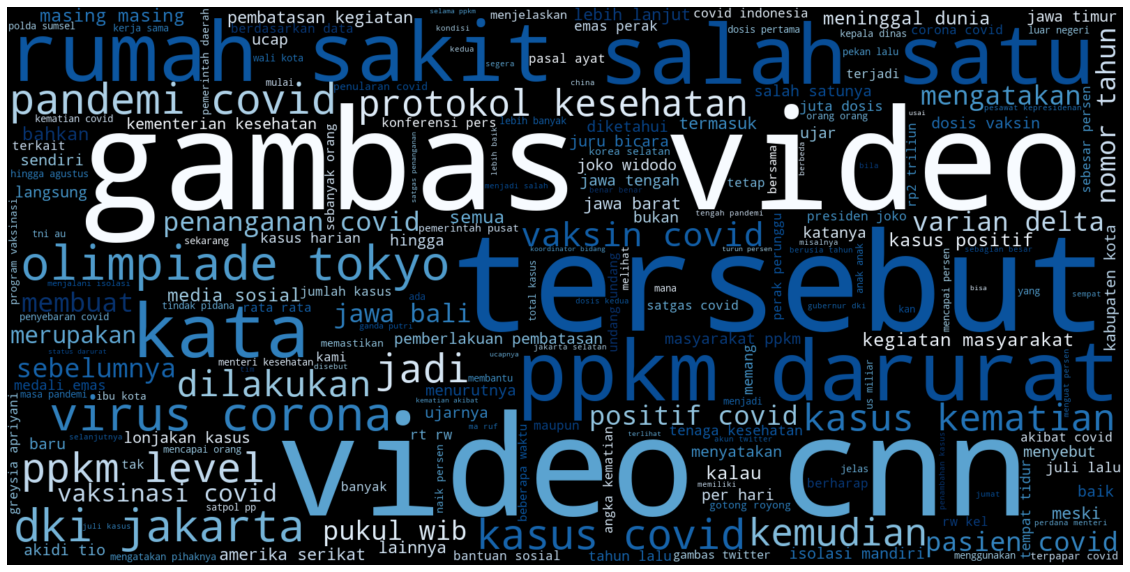

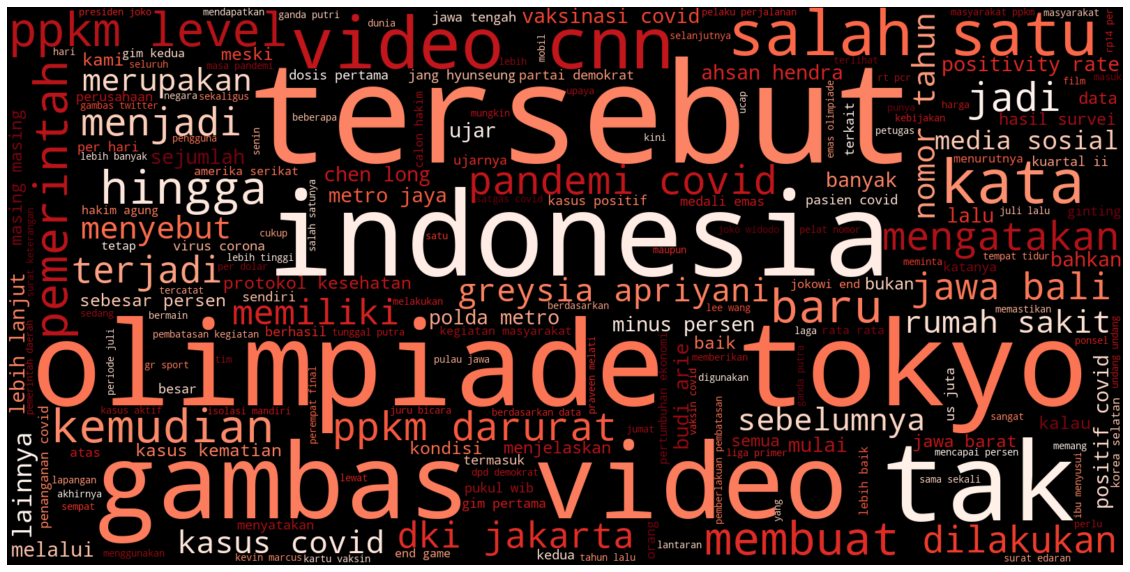

In [66]:
#wordcloud untuk masing-masing kelas pada label
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# label positive
label_pos = df[df["label"]=='pos']
all_text_labelpos = ' '.join(word for word in label_pos["content"])
wordcloud = WordCloud(colormap='Greens', width=1600, height=800, max_font_size=200, 
                      background_color='black').generate(all_text_labelpos)
plt.figure(figsize=(20,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# label neutral
label_neu = df[df["label"]=='neutral']
all_text_labelneu = ' '.join(word for word in label_neu["content"])
wordcloud = WordCloud(colormap='Blues', width=1600, height=800, max_font_size=200, 
                      background_color='black').generate(all_text_labelneu)
plt.figure(figsize=(20,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# label negative
label_neg = df[df["label"]=='neg']
all_text_labelneg = ' '.join(word for word in label_neg["content"])
wordcloud = WordCloud(colormap='Reds', width=1600, height=800, max_font_size=200, 
                      background_color='black').generate(all_text_labelneg)
plt.figure(figsize=(20,18))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# SENTIMENT ANALYSIS

Karena pada dataset terjadi imbalanced data pada kelas-kelas label, maka dilakukan resampling. Ditentukan sebanyak 5.000 data untuk masing-masing kelas pada label

In [122]:
#handling imbalanced data
df_preprocessed = df.copy()
s_1 = df_preprocessed[df_preprocessed['label']=='pos'].sample(5000,replace=True)
s_2 = df_preprocessed[df_preprocessed['label']=='neutral'].sample(5000,replace=True)
s_3 = df_preprocessed[df_preprocessed['label']=='neg'].sample(5000,replace=True)
df_preprocessed = pd.concat([s_1, s_2, s_3])

print(df_preprocessed.shape)
print(df_preprocessed['label'].value_counts(normalize=True))
df_preprocessed.head()

(15000, 2)
neutral    0.333333
neg        0.333333
pos        0.333333
Name: label, dtype: float64


,content,label
4213,atlet selandia baru laurel hubbard mencatat se...,pos
16114,startup social commerce asal indonesia menyasa...,pos
4691,pt asuransi bri life menemukan bukti pelaku ke...,pos
10964,gubernur dki jakarta anies baswedan disebut me...,pos
2126,satuan tugas satgas penanganan covid 19 meng...,pos


In [123]:
#data cleansing
import string, re

def cleansing(data) :
  #lower text
  data=data.lower()

  #hapus punctuation
  remove = string.punctuation
  translator = str.maketrans(remove, ' '*len(remove))
  data = data.translate(translator)

  #remove new line
  data = data.replace('\n', ' ')

#tokenization
  data=re.split('\W', data)
  
  return data


In [124]:
#penerapan pada dataset
review = []
for index, row in df_preprocessed.iterrows():
  review.append(cleansing(row["content"]))

df_preprocessed["content"] = review
df_preprocessed.head()

,content,label
4213,"[atlet, selandia, baru, laurel, hubbard, menca...",pos
16114,"[startup, social, commerce, asal, indonesia, m...",pos
4691,"[pt, asuransi, bri, life, menemukan, bukti, pe...",pos
10964,"[gubernur, dki, jakarta, anies, baswedan, dise...",pos
2126,"[satuan, tugas, , satgas, , penanganan, covid,...",pos


In [125]:
#membagi data menjadi training dan testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_preprocessed['content'],df_preprocessed['label'],
                                                    test_size=0.2, stratify=df_preprocessed['label'], random_state=30)

**KLASIFIKASI SENTIMENT**

In [ ]:
#klasifikasi dengan naive bayes classifier
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train, y_train)
pred=nb.predict(X_test)

In [ ]:
#akurasi model
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

         neg       0.81      0.85      0.83      1000
     neutral       0.74      0.81      0.78      1000
         pos       0.83      0.71      0.77      1000

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.79      3000

